# Bagging for data valuation

This notebook introduces the Data-OOB method, an implementation based on a publication from Kwon and Zou "[Data-OOB: Out-of-bag Estimate as a Simple and Efficient Data Value](https://proceedings.mlr.press/v202/kwon23e.html)" ICML 2023 , using pyDVL.


The objective of this paper is mainly to overcome the computational bottleneck of shapley-based data valuation methods that require to fit a significant number of models to accurately estimate marginal contributions.
The algorithms computes data values from out of bag estimates using a bagging model.

The value can be interpreted as a partition of the OOB estimate, which is originally introduced to estimate the prediction error. This OOB estimate is given as:

$$
\sum_{i=1}^n\frac{\sum_{b=1}^{B}\mathbb{1}(w_{bi}=0)T(y_i, \hat{f}_b(x_i))}{\sum_{b=1}^{B}
\mathbb{1}
(w_{bi}=0)}
$$


## Setup

We begin by importing the main libraries and setting some defaults.

<div class="alert alert-info">

If you are reading this in the documentation, some boilerplate (including most plotting code) has been omitted for convenience.

</div>

In [11]:
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [12]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LogisticRegression

import matplotlib.pyplot as plt
import numpy as np

from pydvl.value import compute_data_oob
from pydvl.utils import Dataset, Utility, Scorer
from pydvl.reporting.scores import compute_removal_score
from pydvl.reporting.plots import shaded_mean_std
from pydvl.value.result import ValuationResult

In [23]:
import pandas as pd

# Specify the URL of the dataset
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data"

# Specify the column names
column_names = [
    "age",
    "workclass",
    "fnlwgt",
    "education",
    "education-num",
    "marital-status",
    "occupation",
    "relationship",
    "race",
    "sex",
    "capital-gain",
    "capital-loss",
    "hours-per-week",
    "native-country",
    "income",
]

# Specify the data types for each column
data_types = {
    "age": int,
    "workclass": "category",
    "fnlwgt": int,
    "education": "category",
    "education-num": int,
    "marital-status": "category",
    "occupation": "category",
    "relationship": "category",
    "race": "category",
    "sex": "category",
    "capital-gain": int,
    "capital-loss": int,
    "hours-per-week": int,
    "native-country": "category",
    "income": "category",
}

# Load the dataset into a pandas DataFrame
data_adult = pd.read_csv(
    url,
    names=column_names,
    sep=",\s*",
    engine="python",
    na_values="?",
    dtype=data_types,
    #nrows=2000,
)

# Drop categorical columns
data_adult = data_adult.drop(
    columns=[
        "workclass",
        "education",
        "marital-status",
        "occupation",
        "relationship",
        "race",
        "sex",
        "native-country",
    ]
)


# Display the first few rows of the dataframe
print(data_adult.head())

   age  fnlwgt  education-num  capital-gain  capital-loss  hours-per-week  \
0   39   77516             13          2174             0              40   
1   50   83311             13             0             0              13   
2   38  215646              9             0             0              40   
3   53  234721              7             0             0              40   
4   28  338409             13             0             0              40   

  income  
0  <=50K  
1  <=50K  
2  <=50K  
3  <=50K  
4  <=50K  


In [24]:
data = Dataset.from_arrays(
    X=data_adult.drop(columns=["income"]).values,
    y=data_adult.loc[:, "income"].cat.codes.values,
)

model = KNeighborsClassifier(n_neighbors=5)

utility = Utility(model, data, Scorer("accuracy", default=0.0))

In [25]:
oob_values = compute_data_oob(utility, n_est=1000, max_samples=0.95)

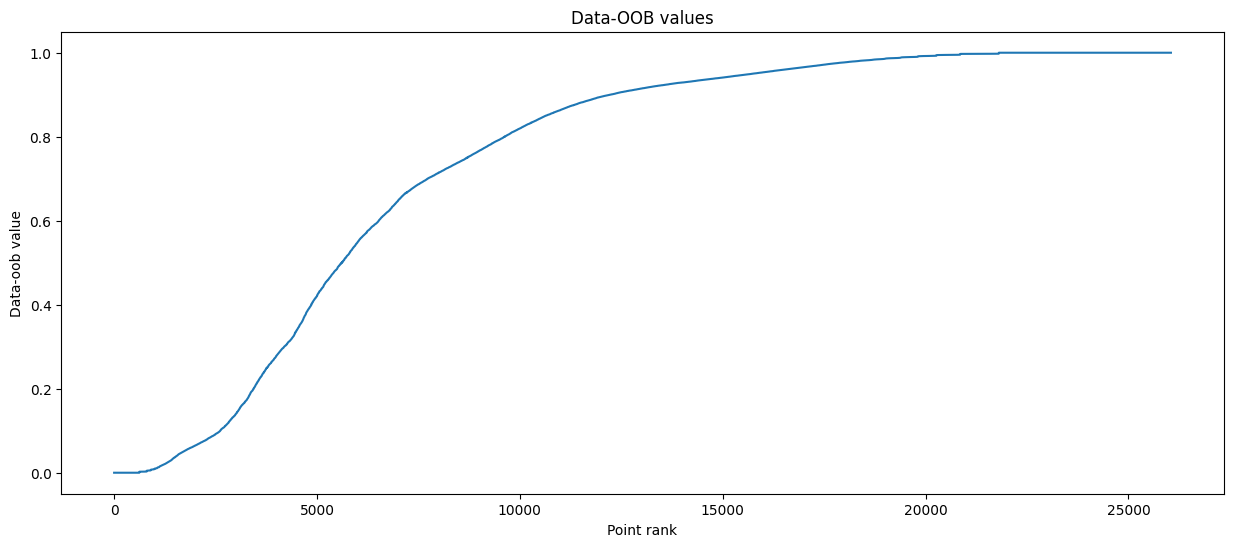

In [27]:
oob_values.sort(key="value")
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=[15, 6])

ax.plot(np.arange(len(oob_values.values)), oob_values.values)
ax.set_title("Data-OOB values")
ax.set_ylabel("Data-oob value")
ax.set_xlabel("Point rank");

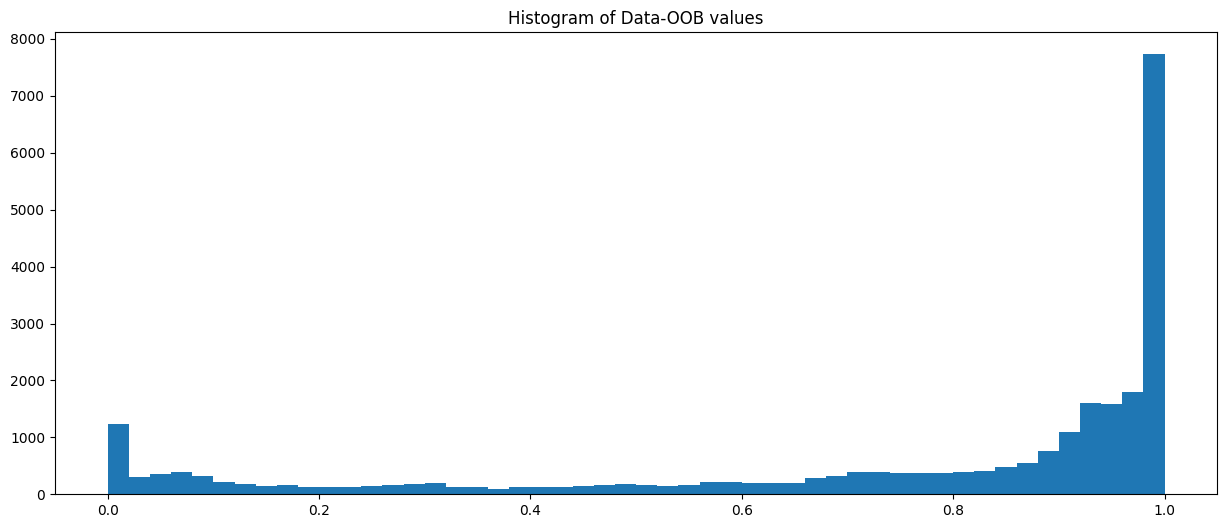

In [28]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=[15, 6])
ax.hist(oob_values.values, bins=50)
ax.set_title("Histogram of Data-OOB values");

## Variance

The variance it the weak learner variance. It is computed with Welford's online algorithm.

In [29]:
plot_list = [(a, b) for a, b in zip(oob_values.values, oob_values.variances)]
plot_list = pd.DataFrame(plot_list).sample(100).sort_values(by=0).values
yerr = [x[1] ** 2 for x in plot_list]

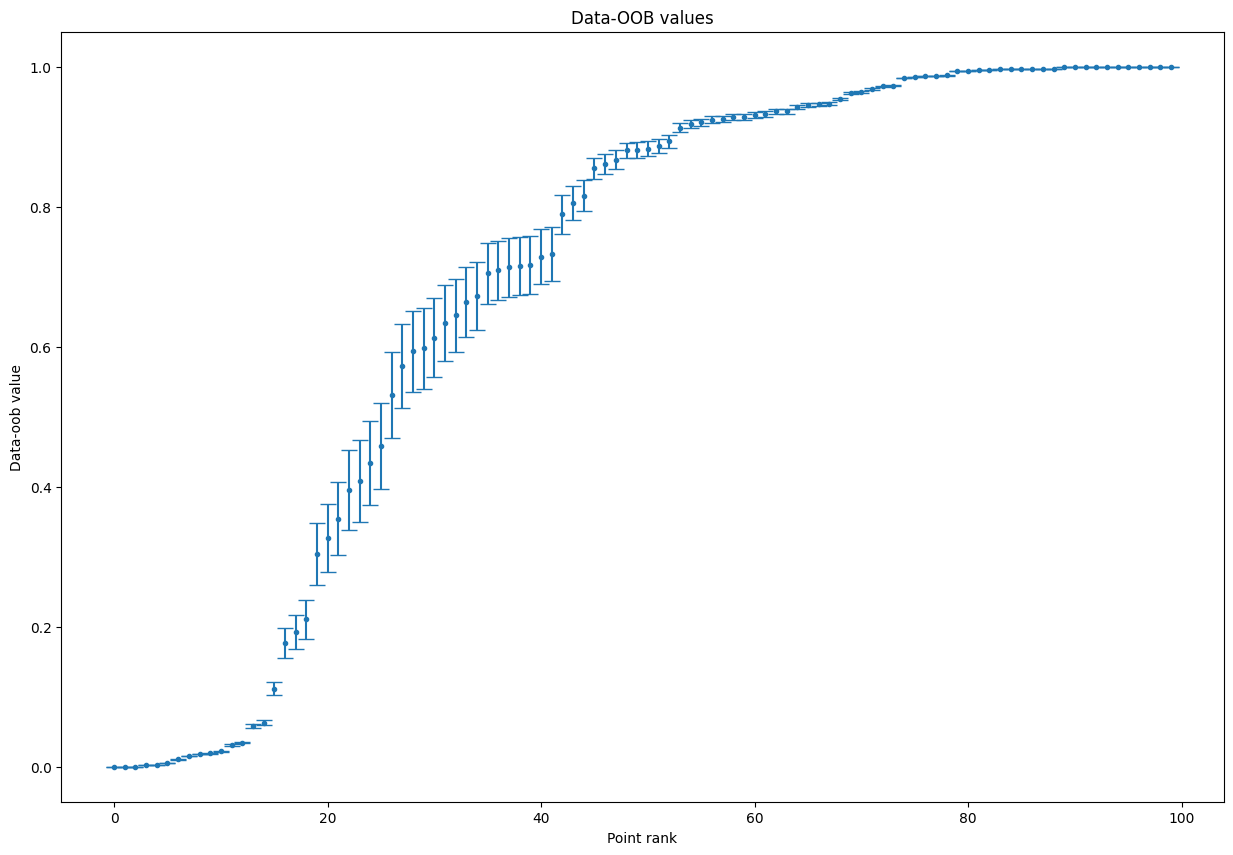

In [30]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=[15, 10])
ax.errorbar(
    x=np.arange(len(yerr)), y=[x[0] for x in plot_list], yerr=yerr, fmt=".", capsize=6
)
plt.title("Data-OOB values")
ax.set_ylabel("Data-oob value")
ax.set_xlabel("Point rank");

# Point removal experiments

The standard procedure for the evaluation of data valuation schemes is the point removal experiment. The objective is to measure the evolution of performance when the best/worst points are removed from the training set. 

In [20]:
mean_colors = ["dodgerblue", "indianred", "limegreen", "darkorange", "darkorchid"]
shade_colors = ["lightskyblue", "firebrick", "seagreen", "gold", "plum"]

In [21]:
all_best_scores = []
all_worst_scores = []

removal_percentages = np.arange(0, 0.99, 0.01)

for i in range(5):
    for method_name in ["Random", "oob"]:
        if method_name == "Random":
            values = ValuationResult.from_random(size=len(utility.data))
        else:
            values = compute_data_oob(utility, n_est=300, max_samples=0.95)

        best_scores = compute_removal_score(
            u=utility,
            values=values,
            percentages=removal_percentages,
            remove_best=True,
        )
        best_scores["method_name"] = method_name
        all_best_scores.append(best_scores)

        worst_scores = compute_removal_score(
            u=utility,
            values=values,
            percentages=removal_percentages,
            remove_best=False,
        )
        worst_scores["method_name"] = method_name
        all_worst_scores.append(worst_scores)

best_scores_df = pd.DataFrame(all_best_scores)
worst_scores_df = pd.DataFrame(all_worst_scores)

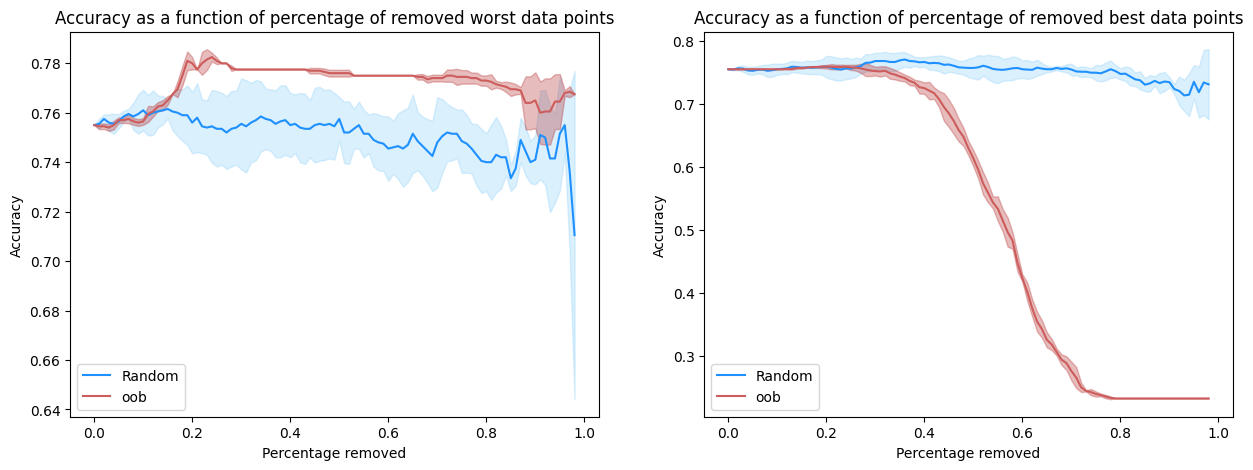

In [22]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=[15, 5])

for i, method_name in enumerate(["Random", "oob"]):
    shaded_mean_std(
        best_scores_df[best_scores_df["method_name"] == method_name].drop(
            columns=["method_name"]
        ),
        abscissa=removal_percentages,
        mean_color=mean_colors[i],
        shade_color=shade_colors[i],
        xlabel="Percentage removed",
        ylabel=utility.scorer._name.capitalize(),
        label=method_name,
        title="Accuracy as a function of percentage of removed best data points",
        ax=ax[1],
    )
    shaded_mean_std(
        worst_scores_df[worst_scores_df["method_name"] == method_name].drop(
            columns=["method_name"]
        ),
        abscissa=removal_percentages,
        mean_color=mean_colors[i],
        shade_color=shade_colors[i],
        xlabel="Percentage removed",
        ylabel=utility.scorer._name.capitalize(),
        label=method_name,
        title="Accuracy as a function of percentage of removed worst data points",
        ax=ax[0],
    )
ax[0].legend()
ax[1].legend()
plt.show();